In [1]:
from utils import RNN, device,  ForecastMetroDataset , cout_0_1

from torch.utils.data import  DataLoader
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_data(CLASSES,LENGTH,DIM_INPUT,BATCH_SIZE):

    PATH = "data/"

    matrix_train, matrix_test = torch.load(open(PATH+"hzdataset.pch", "rb"))
    ds_train = ForecastMetroDataset(
        matrix_train[:, :, :CLASSES, :DIM_INPUT], length=LENGTH)
    ds_test = ForecastMetroDataset(
        matrix_test[:, :, :CLASSES, :DIM_INPUT], length=LENGTH, stations_max=ds_train.stations_max)
    data_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
    data_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False)
    
    
    return data_train,data_test,ds_train,ds_test

In [3]:
# Nombre de stations utilisé
CLASSES = 10
#Longueur des séquences
LENGTH = 20
# Dimension de l'entrée (1 (in) ou 2 (in/out))
DIM_INPUT = 2
#Taille du batch
BATCH_SIZE = 32
data_train,data_test,ds_train,ds_test = load_data(CLASSES,LENGTH,DIM_INPUT,BATCH_SIZE)

In [4]:
def optimisation_rnn(rnn,criterion,optimizer,data_train,data_test,EPOCHS=30):
    losses_tr = []
    losses_te = []
    
    print("Optimisation en cours")

    for _ in tqdm(range(EPOCHS)):
        temp_loss = []
        acc = []
        for  x,y in data_train:

            # we have (batch x length x dim1 x dim2)
            x = x.permute(1,0,2,3)
            x = x.view(x.size(0),x.size(1),-1)
            y = y.permute(1,0,2,3)
            y = y.view(x.size(0),x.size(1),-1)
            # become (length x batch x dim1 x dim2)

            optimizer.zero_grad()
            h_i , liste_h = rnn(x)
            liste_h = torch.stack(liste_h)

            yhat = rnn.decode(liste_h,type='many-to-many')

            loss = criterion(yhat,y)

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                temp_loss.append(loss.item())

        losses_tr.append(np.mean(temp_loss))

        temp_loss_te = []
        
        with torch.no_grad():
            for  x,y in data_test:

                x = x.permute(1,0,2,3)
                x = x.view(x.size(0),x.size(1),-1)
                y = y.permute(1,0,2,3)
                y = y.view(x.size(0),x.size(1),-1)

                h_i , liste_h = rnn(x)
                liste_h = torch.stack(liste_h)

                yhat = rnn.decode(liste_h,type='many-to-many')

                loss = criterion(yhat,y)

                temp_loss_te.append(loss.item())

        losses_te.append(np.mean(temp_loss_te))


    plt.figure(figsize=(10,5))
    plt.title("MSE")
    plt.plot(losses_tr,label="Train")
    plt.plot(losses_te,label="Test")
    plt.legend()
    plt.show()
    
    
    return rnn

### Taille de sequence 20

Optimisation en cours


100%|███████████████████████████████████████████| 30/30 [00:05<00:00,  5.69it/s]


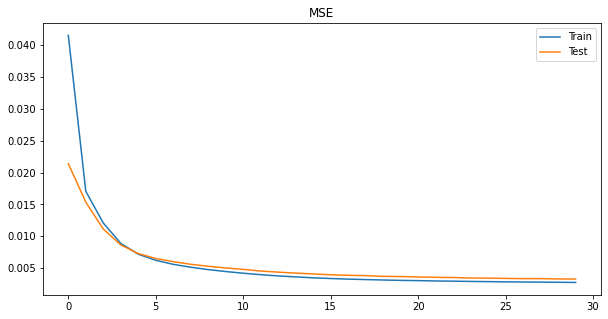

In [5]:
# Prédiction de séries temporelles

# sequences multivariées
dim_in = CLASSES * DIM_INPUT 
dim_lat = 30
dim_out = CLASSES * DIM_INPUT
rnn = RNN(dim_in,dim_lat,dim_out)


LEARNING_RATE = 1e-3
EPOCHS = 30


mse = nn.MSELoss()
optimizer = torch.optim.Adam(params=rnn.parameters() ,lr=LEARNING_RATE,weight_decay=1e-4)

rnn = optimisation_rnn(rnn,mse,optimizer,data_train,data_test,EPOCHS)

In [6]:
#### INFERENCE 

def get_previsions(data,indice_seq,generation_len,station,rnn,LENGTH):
    
    print("Previsions en cours")
    
    done = np.arange(LENGTH-1)
    prevision = np.arange(LENGTH-1, LENGTH-1+generation_len)

    sequence = data.__getitem__(indice_seq)[0]
    sequence = sequence.view(sequence.size(0) , 1,sequence.size(1)*sequence.size(2))

    new_states = torch.zeros(generation_len,CLASSES*DIM_INPUT)

    state_t_1 , liste_h_state = rnn(sequence)
    new_states[0] = rnn.decode(state_t_1,type='many-to-many')


    for i in range(generation_len-1):

        # generate step t+i
        state_t_1 = rnn.one_step(new_states[i] ,state_t_1)
        new_states[i+1] = rnn.decode(state_t_1,type='many-to-many')

    new_states = torch.stack([state.view(CLASSES,DIM_INPUT) for state in new_states]).detach().numpy()

    sequence = ds_test.__getitem__(indice_seq)[0]

    plt.figure(figsize=(15,8))
    plt.subplot(121)

    plt.title(f"Les flux pour la station {station} , sequence {indice_seq}")
    plt.plot(done,sequence[: , station , 0],'red',label='Flux Entrant')
    plt.plot(prevision,new_states[: , station , 0],'green',label='Flux Entrant Previsionnel')
    plt.legend()

    plt.subplot(122)
    plt.title(f"Les flux pour la station {station} , sequence {indice_seq}")
    plt.plot(done,sequence[: , station , 1],'blue',label='Flux Sortant')
    plt.plot(prevision,new_states[: , station , 1],'green',label='Flux Sortant Previsionnel')
    plt.legend()
    plt.show()

Previsions en cours


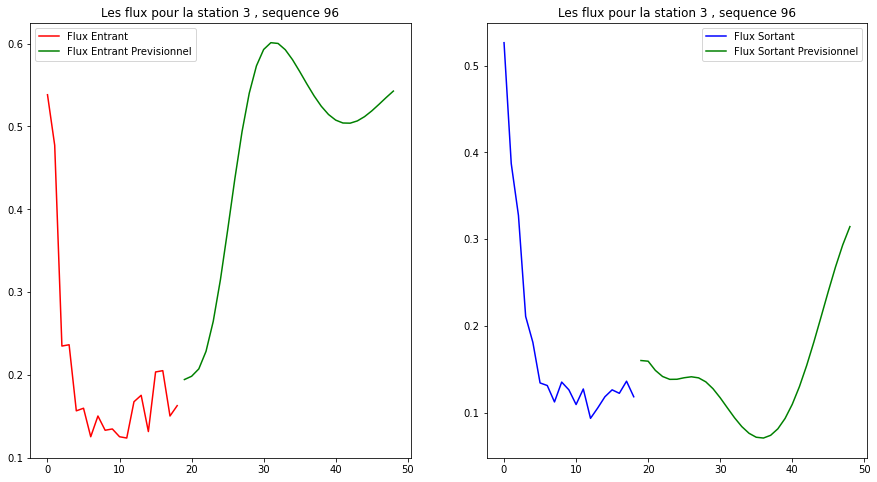

In [7]:
indice_seq = 96
generation_len = 30
station = 3

get_previsions(ds_test,indice_seq,generation_len,station,rnn,LENGTH)

Previsions en cours


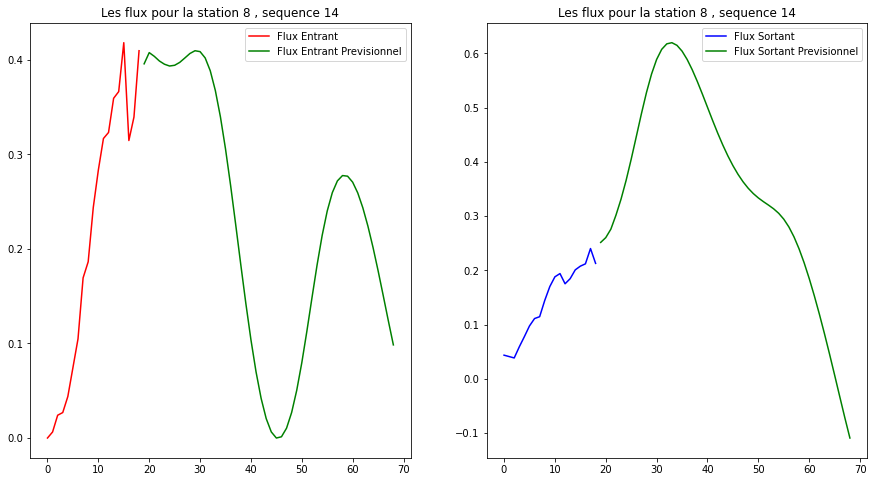

In [8]:
indice_seq = 14
generation_len = 50
station = 8

get_previsions(ds_test,indice_seq,generation_len,station,rnn,LENGTH)

### Taille de sequence 50

In [9]:
#Longueur des séquences
LENGTH = 50
data_train,data_test,ds_train,ds_test = load_data(CLASSES,LENGTH,DIM_INPUT,BATCH_SIZE)

Optimisation en cours


100%|███████████████████████████████████████████| 30/30 [00:05<00:00,  5.27it/s]


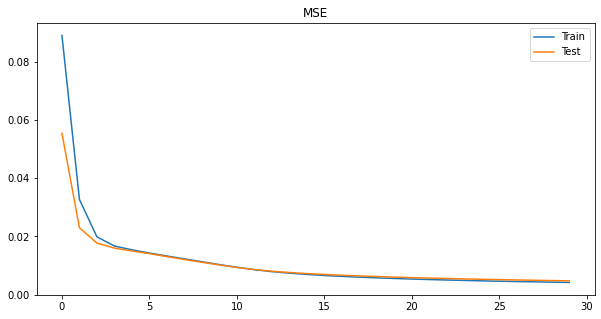

In [10]:
# Prédiction de séries temporelles

# sequences multivariées
dim_in = CLASSES * DIM_INPUT 
dim_lat = 30
dim_out = CLASSES * DIM_INPUT
rnn = RNN(dim_in,dim_lat,dim_out)


LEARNING_RATE = 1e-3
EPOCHS = 30


mse = nn.MSELoss()
optimizer = torch.optim.Adam(params=rnn.parameters() ,lr=LEARNING_RATE,weight_decay=1e-4)

rnn = optimisation_rnn(rnn,mse,optimizer,data_train,data_test,EPOCHS)

Previsions en cours


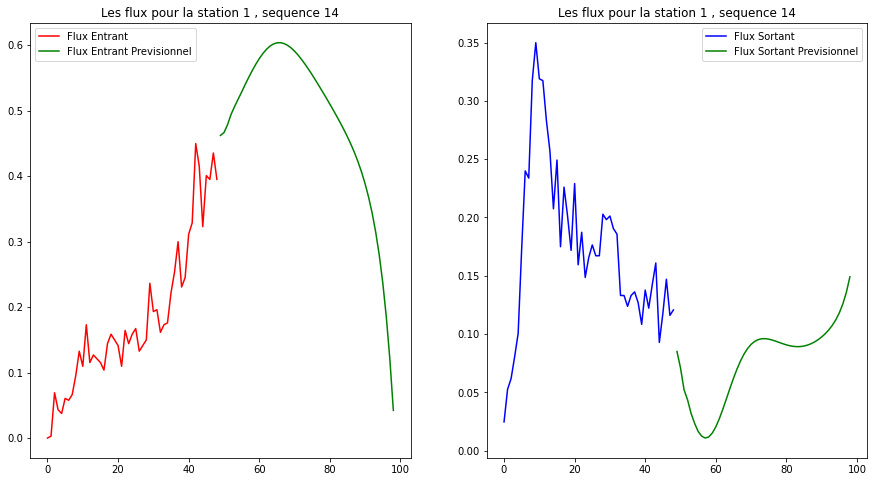

In [13]:
indice_seq = 14
generation_len = 50
station = 1

get_previsions(ds_test,indice_seq,generation_len,station,rnn,LENGTH)